### Linear Regression the Bayesian Way

This is a simple notebook demonstrating three approaches to fitting Bayesian Linear Regression:

* The brute force evaluation of the unnormalized posterior at all positions 
* The MCMC (just for completeness)
* The Bayes by Backprop approach

In [15]:
# Checking if running in colab and if installing the requited versions
# Trick from: https://stackoverflow.com/questions/53581278/test-if-notebook-is-running-on-google-colab 
try:
  import google.colab
  IN_COLAB = True
  !pip install tensorflow==2.0.0-alpha0
  !pip install tfp-nightly
except:
  IN_COLAB = False

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)
%matplotlib inline
tfd = tfp.distributions
print("TFB Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFB Version 0.7.0-dev20190426
TF  Version 2.0.0-alpha0


Creation of some data

((50, 1), (50,), dtype('float64'))

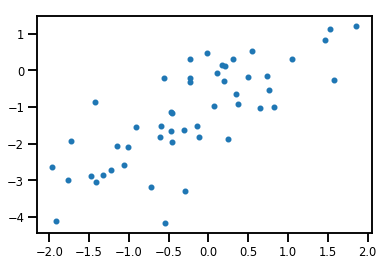

In [17]:
num = 50
np.random.seed(42)
#x = np.concatenate((np.linspace(-10,-1,num), np.linspace(1,10,num))).reshape(2*num,1)
x = np.random.normal(0,1,(num,1))
y = 1 * x[:,0] - 1 + 1.*np.random.normal(0,1,num) 
plt.scatter(x,y, marker='.')
x.shape, y.shape, y.dtype

### Fitting a linear model

In [18]:
from sklearn import linear_model
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(x,y)
# The coefficients
print('Coefficients: \n', regr.coef_)
print('Coefficients: \n', regr.intercept_)

Coefficients: 
 [1.10307565]
Coefficients: 
 -0.9589782612132034


### Brute Force

$$
    P(w|d) \thicksim \frac{P(d|w) P(w)}{P(d)} 
$$

We can calculate $P(d|w) P(w) =: \tt{unnormalized{\_}posterior}$ quite easily. For convenience we calculate the log.

In [19]:
ytensor = y.reshape([len(y),1])
def unnormalized_posterior(w):
    rv_a = tfd.Normal(loc=0., scale=1.) #This is the prior for the slope and
    rv_b = tfd.Normal(loc=0., scale=1.) #intercept.    
    y_prob = tfd.Independent(tfd.Normal(loc=x*w[0]+w[1], scale=1.0), reinterpreted_batch_ndims=1)
    #y_prob = tfd.Normal(loc=x*w[0]+w[1], scale=1.0)
    return (
         tf.reduce_mean(
             rv_a.log_prob(w[0])+ 
             rv_b.log_prob(w[1])+
             y_prob.log_prob(ytensor), axis=-1) 
    )

In [20]:
 tfd.Normal(loc=0., scale=5.).stddev()

<tf.Tensor: id=5, shape=(), dtype=float32, numpy=5.0>

In [21]:
w = tf.Variable([[1.0],[2.0]],dtype=tf.float32)
unnormalized_posterior(w)

<tf.Tensor: id=87, shape=(), dtype=float32, numpy=-10.078209>

We now evaluate the unnormalized posterior on a $\tt{nbins} \times \tt{nbin}$ grid, ranging from $[-3,+3]$ for the both the intercept and the slope. Outside this range the probability is (nearly) zero and we can use the values to normalize unpost to become a real posterior.

In [22]:
nbins = 60
ai, bi = np.mgrid[-3:3:nbins*1j, -3:3:nbins*1j] #wtf is j?
ws = np.vstack([ai.flatten(), bi.flatten()])
unpost = np.zeros((nbins*nbins))
for i in range((nbins*nbins)):
    unpost[i] = unnormalized_posterior(tf.Variable([[ws[0,i]],[ws[1,i]]],dtype=tf.float32))
unpost = np.exp(unpost.reshape(ai.shape))
post = unpost / np.sum(unpost) #<-- We normalize

Text(0.5, 1.0, 'Posterior Weight Distribution')

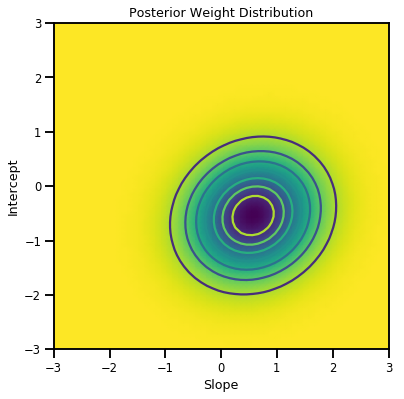

In [23]:
fig = plt.figure(figsize=(6,6))
plt.pcolormesh(ai, bi, -unpost, shading='gouraud',cmap="viridis")
plt.contour(ai, bi, post)
plt.xlabel('Slope')
plt.ylabel('Intercept')
plt.title('Posterior Weight Distribution')

We can now use the values of the posterior: 

* Mean Value (should be at 0.7, -0.7) it is not (1, -1) this is due to the fact that the prior has still an influcence. As an exercise go and change the values.

* Standard Deviation TODO

* Predictive Distribution TODO

#### Shortcommings of the brute force approach
So we are done. Let's move to networks and fit the 50 million weights. 
Calculating the unnormalized posterior is easy. Done? Wait a moment. In the above example with the two weights we evaluated the unnormalized probability distribution at $\tt{nbins} \times \tt{nbins}$. If we would also fit the sigma parameter that would be $\tt{nbins}^3$ parameters. So a network with 50 million parameters would need $\tt{nbins}^{50 million}$. Let's be satisfied with only $\tt{nbins}=10$. Then we would have $10^{50'000'000}$. If you could do one billion evaluations per second, that would be still take you $10^{50'000'000}/10^9 = 10^{49'999'991}$ seconds. Even for a small network with 100 weights that would take $10^{100}/10^9 = 10^{91}$ seconds. Fun fact go type `10^100 / 10^9 seconds` into [Wolfram Alpha](https://www.wolframalpha.com/input/?i=10%5E100+%2F+10%5E9+seconds). Solution it will take $3.169 \cdot 10^{83}$ years about 10 billion times longer than the age of the univers! [Forget it Ming!](https://getyarn.io/yarn-clip/ecb8c167-324e-4532-9a96-6b0b958fbe52)

This brute force approach does not do the trick for Bayesian Neural Networks. What next? There is an approach called Markov Chain Monte Carlo MCMC for short. It will work for small problems say 10-100 weights but not for large networks. 

### Using MCMC
In the MCMC method you start at a certain value (a and b). Then you step to nearby values (a' and b') if the probability for the nearby value is higher, you accept it. If not you you accept if with the probability $P((a',b')|d)/P((a,b)|d)$. The great thing is that just need the unormalized probability in that case. So we jump from state to state and simply count how often we are in the state XXXXXXTODO.

In MCMC if the prior is wrong, and you don't have any mass at the real values, you are in trouble! 
Therefore use a slope and intercept within the prior. We are lucky in our case. Another solution would be to use a vage prior with a very broad sigma.


The easiest MCMC-algorithm is random walk metropolis. This is included in TensorFlow probability.


In [24]:
#The sampler
metropolis=tfp.mcmc.RandomWalkMetropolis(target_log_prob_fn=unnormalized_posterior,seed=42)

#Does create a chain of samples
states, kernel_results = tfp.mcmc.sample_chain(
        num_results=400,
        current_state = tf.Variable([[5],[-5]],dtype=tf.float32),
        kernel=metropolis)

/Users/oli/.virtualenvs/tensorflow_prob/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Text(0, 0.5, 'Sampled values of a / b')

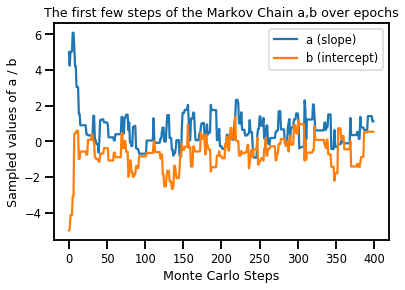

In [25]:
plt.plot(states[:,0])
plt.plot(states[:,1])
plt.legend(('a (slope)','b (intercept)'))
plt.title("The first few steps of the Markov Chain a,b over epochs")
plt.xlabel('Monte Carlo Steps')
plt.ylabel('Sampled values of a / b')

Text(0, 0.5, 'b intercept')

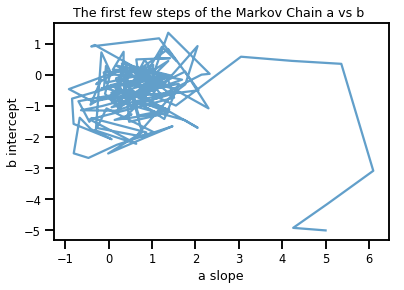

In [26]:
import pandas as pd
df=pd.DataFrame({'xvalues': states[0:400,0,0], 'yvalues': states[0:400,1,0] })
plt.title("The first few steps of the Markov Chain a vs b ")
plt.plot('xvalues', 'yvalues', data=df, alpha=0.7) #third argument, it could be several chains
plt.xlabel('a slope')
plt.ylabel('b intercept')

How often a chain visits a certain value (combination a,b) is proportional to the posterior probability $P((a,b)|d)$ 
You see the chain is often at regions with hight probability. Around $a=1$ and $b=-1$

slope 0.5618837475776672  std 0.6890685558319092
inter -0.3153720498085022  std 0.7005372047424316


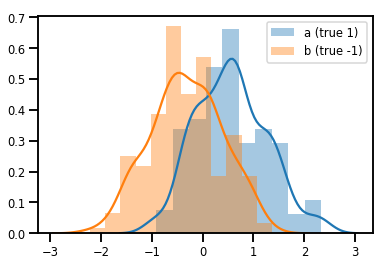

In [27]:
sns.distplot(states[200:,0], norm_hist=True, kde=True)
sns.distplot(states[200:,1], norm_hist=True, kde=True)
plt.legend(('a (true 1)','b (true -1)'))
print("slope {}  std {}".format(np.mean(states[200:,0]), np.std(states[200:,0])))
print("inter {}  std {}".format(np.mean(states[200:,1]), np.std(states[200:,1])))

For a better statistic we want to have more samples, we increase the number of results. To be fast, we compile the calculations into a TensorFlow function.

In [28]:
import time
start = time.time()
w = current_state = tf.Variable([[5],[-5]],dtype=tf.float32)
@tf.function #Much faster, when compiling
def run_chain():
    states, kernel_results = tfp.mcmc.sample_chain(
        num_results=20000,
        current_state = w,
        kernel=metropolis)
    return(states, kernel_results)
states, kernel_results = run_chain()
print(time.time() - start, " seconds")

/Users/oli/.virtualenvs/tensorflow_prob/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


16.926316022872925  seconds


Actually we have 2-D density and should reflect this fact in the plot. There can be correlations between the variables. Let's look at the covariance matrix.

In [29]:
cov_mcmc = np.cov(np.transpose(states[200:,:,0]))
cov_mcmc

array([[0.54475029, 0.05935647],
       [0.05935647, 0.53292812]])

slope 0.5717616081237793  std 0.7380720053014149
inter -0.536741316318512  std 0.7300192613536792


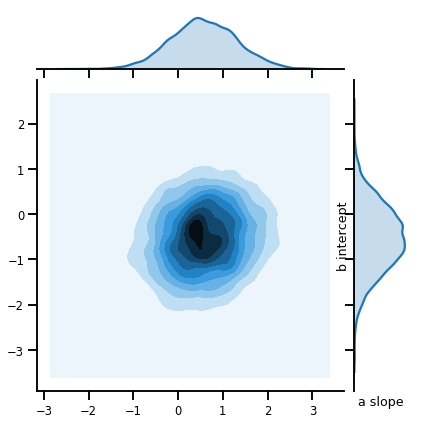

In [30]:
sns.jointplot(x=states[200:,0], y=states[200:,1], kind='kde')

plt.xlabel('a slope')
plt.ylabel('b intercept')
a_locmcmc = np.mean(states[200:,0])
b_locmcmc = np.mean(states[200:,1])
print("slope {}  std {}".format(a_locmcmc, np.sqrt(cov_mcmc[0,0])))
print("inter {}  std {}".format(b_locmcmc, np.sqrt(cov_mcmc[1,1])))

### Comparison

First we compare the MCMC Result, with the brute-force result. In the density plot from the brute force method, we plot the isolines of constant variation. 

In [31]:
#taken from https://scipython.com/book/chapter-7-matplotlib/examples/bmi-data-with-confidence-ellipses/
def get_cov_ellipse(cov, centre, nstd, **kwargs):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """

    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * nstd * np.sqrt(eigvals)
    return Ellipse(xy=centre, width=width, height=height,
                   angle=np.degrees(theta), **kwargs)

/Users/oli/.virtualenvs/tensorflow_prob/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'color'
  s)


(-3, 3)

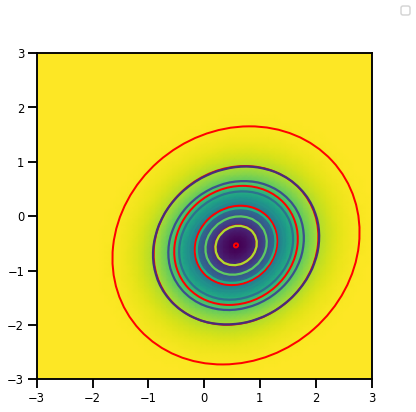

In [32]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.pcolormesh(ai, bi, -unpost, shading='gouraud',cmap="viridis")
ax.contour(ai, bi, post, color='green')
for s in (0.05,0.5,1.5,1,2,3):
    e = get_cov_ellipse(cov_mcmc, (a_locmcmc, b_locmcmc), s, fill=False, linewidth=2,color='r')
    ax.add_artist(e)
fig.legend(('Brute Force', 'MCMC'))
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)

Since there is no approximation, we get a quite a remarkable agreement. Let's look at the variational approximation.

### Variational Method
The Markov Chain Monte Carlo Method is still too slow. One fix is not randomly jump around in the high dimensional space but to be quided. There is many research on that (Hamiltonian, No-UTurn Sample XXXsomebody with knowlegde please add).

Another trick, used especially for Neural Networks is Variational Bayes. 

Text(0, 0.5, 'Loss ??? ELBO? Check')

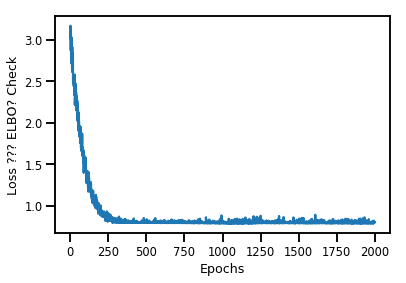

In [33]:
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (num * 1.0)
model = tf.keras.Sequential([
    tfp.layers.DenseReparameterization(1,kernel_divergence_fn=kernel_divergence_fn)
])
sgd = tf.keras.optimizers.Adam(lr=.005)
model.compile(loss='mse', optimizer=sgd, metrics=['mse'])
hist = model.fit(x, y, epochs=2000, batch_size=num, verbose=False)
plt.plot(hist.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss ??? ELBO? Check')

In [34]:
[weight.name for layer in model.layers for weight in layer.weights]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_reparameterization (De multiple                  3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


#### Let's look into details
We now fit some epochs and record the variational parameters while fitting, using Keras's callback mechanism. We also use unusual start values to see something happening.

In [37]:
epochs = 5000
weights = np.zeros((epochs,5))
def myLogger(epoch, logs):
    w = model.get_weights()
    #Names of the weights via [weight.name for layer in model.layers for weight in layer.weights]
    #From https://stackoverflow.com/questions/40444083/weights-by-name-in-keras
    a_loc = w[0].flatten() #kernel_posterior_loc
    a_sca = tf.math.softplus(w[1].flatten()) #kernel_posterior_untransformed_scale see https://github.com/tensorflow/probability/issues/258
    b_loc = w[2].flatten() #Same for bias
    b_sca = tf.math.softplus(w[3].flatten())
    #print(b_sca)
    weights[epoch] = np.asarray((epoch, a_loc, a_sca, b_loc, b_sca))
    if (epoch < 3):
        print(weights[epoch])
    
batch_print_callback = tf.keras.callbacks.LambdaCallback(on_epoch_begin=myLogger)

inputs = tf.keras.layers.Input(shape=(x.shape[1],))

# We set the posterior by hand to make some noise
kernel_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(
    loc_initializer=tf.compat.v1.initializers.random_normal(mean=-1.,stddev=0.1), #Will go to -> 1
    untransformed_scale_initializer=tf.compat.v1.initializers.random_normal(mean=1., stddev=0.00001),
    is_singular=False
)

bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn( #make some noise
    loc_initializer=tf.compat.v1.initializers.random_normal(mean=2.,stddev=0.1), #Will go to --> -1
    untransformed_scale_initializer=tf.compat.v1.initializers.random_normal(mean=1., stddev=0.00001),
    is_singular=False)


kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (num * 1.0)
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (num * 1.0)

out = tfp.layers.DenseReparameterization(1,
                                         bias_posterior_fn=bias_posterior_fn,
                                         kernel_posterior_fn=kernel_posterior_fn,
                                         kernel_divergence_fn=kernel_divergence_fn,
                                         bias_divergence_fn=bias_divergence_fn,
                                         bias_prior_fn=tfp.layers.default_multivariate_normal_fn
                                        )(inputs)
model = tf.keras.models.Model(inputs=inputs, outputs=out)
sgd = tf.keras.optimizers.SGD(lr=.001)
#sgd = tf.keras.optimizers.Adam(lr=.001)
model.compile(loss='mse', optimizer=sgd, metrics=['mse'])
hist = model.fit(x, y, batch_size=num, callbacks=[batch_print_callback],epochs=epochs, verbose=False)

[ 0.         -0.94808179  1.31326902  1.99980199  1.3132633 ]
[ 1.         -0.94322133  1.31262755  1.99627745  1.31574261]
[ 2.         -0.93316376  1.3011694   1.98850858  1.31632042]


In [38]:
weights.shape

(5000, 5)

(0, 5)

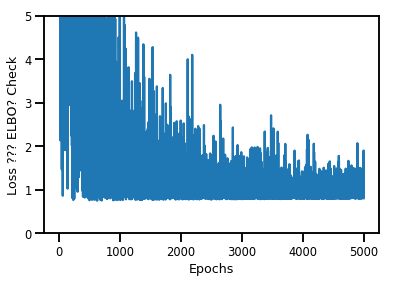

In [39]:
plt.plot(hist.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss ??? ELBO? Check')
plt.ylim(0,5)

In [40]:
preds = [model.predict([0]) for i in range(1000)] #We average over the stochastic outsputs
final_b = np.mean(preds) #We average over the 
print(final_b)
at1 = np.mean([model.predict([1]) for i in range(1000)])
#print(at1)
print("Slope ", at1 - final_b)
model.get_weights()

-0.94574654
Slope  1.0990067


[array([[1.0878469]], dtype=float32),
 array([[-1.0580043]], dtype=float32),
 array([-0.9528463], dtype=float32),
 array([-1.1461134], dtype=float32)]

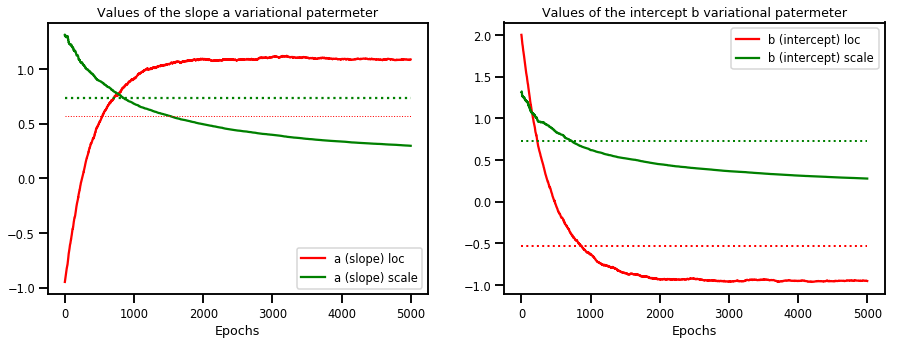

In [41]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 5), facecolor='w', edgecolor='k')

ax = plt.subplot(121)
ax.plot(weights[:,1], color='r')
ax.plot(weights[:,2], color='g')
ax.plot([0, epochs], [a_locmcmc, a_locmcmc], linewidth=1,color='r', linestyle=':')
ax.plot([0, epochs], [np.sqrt(cov_mcmc[0,0]), np.sqrt(cov_mcmc[0,0])], color='g', linestyle=':')
ax.legend(('a (slope) loc', 'a (slope) scale'))
plt.title("Values of the slope a variational patermeter")
plt.xlabel('Epochs')

ax = plt.subplot(122)
ax.plot(weights[:,3], color='r')
ax.plot(weights[:,4],color='g')
ax.plot([0, epochs], [b_locmcmc, b_locmcmc], linewidth=2, color='r', linestyle=':')
ax.plot([0, epochs], [np.sqrt(cov_mcmc[1,1]), np.sqrt(cov_mcmc[1,1])], linewidth=2,color='g', linestyle=':')
ax.legend(('b (intercept) loc', 'b (intercept) scale'))

plt.title("Values of the intercept b variational patermeter")
plt.xlabel('Epochs')

plt.show()

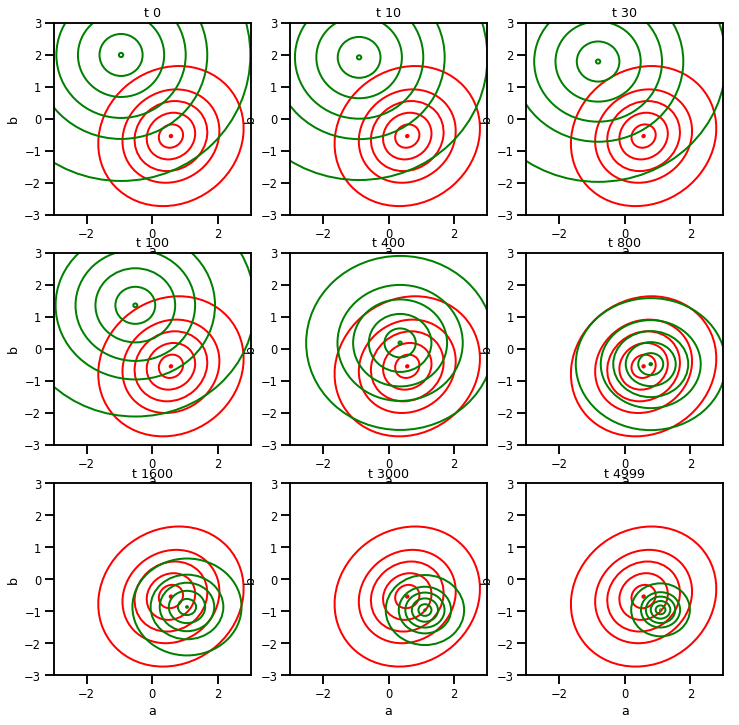

In [43]:
fig = plt.figure(figsize=(12,12))

for i,time in enumerate((0,10,30,100,400,800,1600,3000, 4999)): 
    ax = fig.add_subplot(3,3,1+i)
    for s in (0.05,0.5,1.5,1,2,3):
        e = get_cov_ellipse(cov_mcmc, (a_locmcmc, b_locmcmc), s, fill=False, linewidth=2,color='r')
        ax.add_artist(e)

    w = weights[time,:] #(epoch, a_loc, a_sca, b_loc, b_sca)
    cov_var = np.array([w[2]**2,0.0,0.0,w[4]**2]).reshape((2,2))
    for s in (0.05,0.5,1.5,1,2,3):
        e = get_cov_ellipse(cov_var, (w[1], w[3]), s, fill=False, linewidth=2,color='g')
        ax.add_artist(e)

    ax.set_xlim(-3,3)
    ax.set_ylim(-3,3)
    plt.ylabel('b')
    plt.xlabel('a')
    plt.title('t {}'.format(time))

In [ ]:
# to animate: https://towardsdatascience.com/how-to-create-animated-graphs-in-python-bb619cc2dec1

### Variational inference by hand

We now calculate the variational inference "by hand" using no Keras layers. 

The Variational Inference involves the calculation of the KL Divergence between.
$$
KL(p(q|\theta) || P(w) 
$$

For Gaussians, we can calculate this as (see Kingma Welling 2013 VAE paper in the appendix)

$$
    KL(q(\mu_1|\sigma_1) || N(0,1)) = -\frac{1}{2} \left{ log(\sigma^2) - \mu^2 - \sigma^2 \right}
$$


In [44]:
mu = 1.
s  = 2.
print(tfd.Normal(mu, s).kl_divergence(tfd.Normal(0, 1)))
-(1. + np.log(s**2) - mu - s**2)/2.


tf.Tensor(1.3068528, shape=(), dtype=float32)


1.3068528194400546

In [45]:
# Variational parameters
# 0 b_u =  tf.Variable(0.0) # Mean of bias / intercept term
# 1 b_r =  tf.Variable(-3.0) # Rho of bias  / intercept term
# 2 a_u =  tf.Variable(0.0) # Same for intecept
# 3 a_r =  tf.Variable(-3.0)
w = tf.Variable((0,-3.0,0,-3.0)) #We need all in one array 

# The noise term
e = tfd.Normal(loc=0., scale=1.)

# The Distributions of the weights and the biases
# a_rv = tfd.Normal(w[2], tf.math.softplus(w[3]))
# b_rv = tfd.Normal(w[0], tf.math.softplus(w[1]))

# The priors  we need 0,1 due to KL-Divergence
pa = tfd.Normal(loc=0., scale=1)
pb = tfd.Normal(loc=0., scale=1)

epochs = 1000

loss_history = np.zeros(epochs)
loss_history_mse = np.zeros(epochs)
loss_history_kl = np.zeros(epochs)
loss_history_kl2 = np.zeros(epochs)
for i in range(epochs):
    with tf.GradientTape() as tape: 
        # The linear regression with the reparameterization trick
        sa = tf.math.softplus(w[3])
        sb = tf.math.softplus(w[1])
        y_hat = (w[2] + e.sample() * sa) * x + w[0] + e.sample()*sb
        loss_mse = tf.reduce_sum(tf.math.square(ytensor - y_hat))
        #KL-Divergence with Gaussian Priors 
        loss_kl = -0.5*(tf.math.log(sa*sa) - sa*sa - w[2]*w[2] + tf.math.log(sb*sb) - sb*sb - w[0]*w[0])
        #loss_kl = pa.kl_divergence(a_rv) + pb.kl_divergence(b_rv) #also to MaxLike
        loss = loss_mse + loss_kl
        loss_history[i] = loss.numpy()
        loss_history_kl[i] = loss_kl.numpy()
        loss_history_mse[i] = loss_mse.numpy()
    grads = tape.gradient(loss, w)
    #w = w - 0.0001*grads # Does not work in eager
    w = tf.Variable(w - 0.0001*grads) # Gradient Descent 
    

<tf.Variable 'Variable:0' shape=(4,) dtype=float32, numpy=array([-0.94813377, -2.926653  ,  1.0949728 , -2.9283206 ], dtype=float32)>
b =  -0.94813377   0.0521902  a =  1.0949728   0.05210545


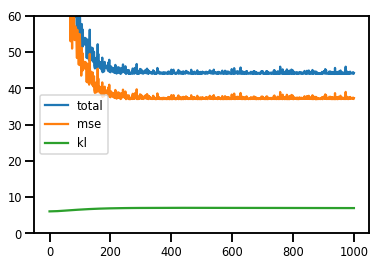

In [46]:
print(w)
plt.plot(loss_history)
plt.plot(loss_history_mse)
plt.plot(loss_history_kl)
plt.ylim(0,60)
plt.legend(('total', 'mse', 'kl', 'kl_1'))
plt.show()
print('b = ', w[0].numpy(), ' ', tf.math.softplus(w[1]).numpy(), 
      ' a = ', w[2].numpy(), ' ',  tf.math.softplus(w[3]).numpy())

Note in the figure above, the KL Term does not depend on the number of data points. The MSE loss, however, does. Increasing the number of data point will enlarge the MSE loss but not the KL term. Hence, the importance of the prior decreases.

Comparing the losses. In DL it is common to scale the losses by the number of data points. The MSE is scaled by the number of datapoints, therefore the KL Term should also scaled according to the data points. Doing so yields.

In [55]:
np.min((loss_history[-100:] / num)), np.min(hist.history['loss'][-100:])



 


(0.8794587707519531, 0.7935686707496643)